In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [49]:
for q in session.query(Measurement):
    print(q.__dict__)

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x0000013AA346C890>, 'station': 'USC00519397', 'id': 1, 'prcp': 0.08, 'tobs': 65.0, 'date': '2010-01-01'}
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x0000013AA346CD10>, 'station': 'USC00519397', 'id': 2, 'prcp': 0.0, 'tobs': 63.0, 'date': '2010-01-02'}
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x0000013AA346DD30>, 'station': 'USC00519397', 'id': 3, 'prcp': 0.0, 'tobs': 74.0, 'date': '2010-01-03'}
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x0000013AA346DA30>, 'station': 'USC00519397', 'id': 4, 'prcp': 0.0, 'tobs': 76.0, 'date': '2010-01-04'}
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x0000013AA346E0F0>, 'station': 'USC00519397', 'id': 5, 'prcp': None, 'tobs': 73.0, 'date': '2010-01-06'}
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x0000013AA346E3F0>, 'station': 'USC00519397', 'id': 6, 'pr

In [10]:
# Find the most recent date in the data set.
latest_date = session.query(Measurement).order_by(Measurement.date.desc()).first().date
latest_date

'2017-08-23'

<Axes: xlabel='Date', ylabel='Inches'>

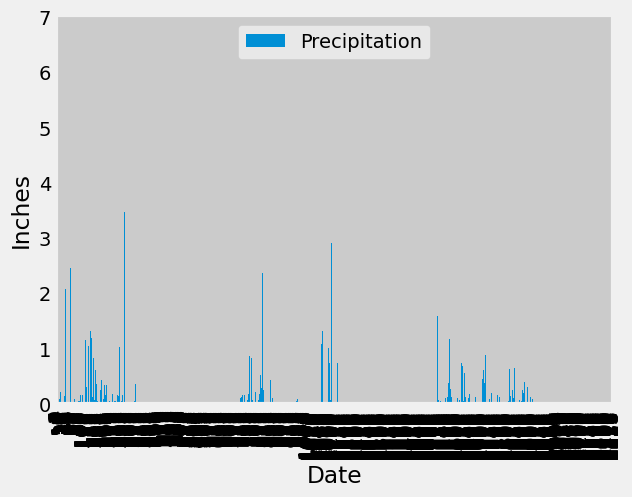

In [44]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
# strptime() function taken from Python documentation: https://docs.python.org/3/library/datetime.html#strftime-strptime-behavior
latest_date_dt = dt.datetime.strptime(latest_date, "%Y-%m-%d")
starting_date = (latest_date_dt - dt.timedelta(days=365)).strftime("%Y-%m-%d")

# Perform a query to retrieve the data and precipitation scores
prcp_query = session.query(Measurement.date, Measurement.prcp)\
    .order_by(Measurement.date)\
    .filter(Measurement.date >= starting_date)\
    .all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
date_list = [prcp_query[x][0] for x in range(len(prcp_query))]
prcp_list = [prcp_query[x][1] for x in range(len(prcp_query))]
prcp_df = pd.DataFrame(data={"Date": date_list, "Precipitation": prcp_list})

# Sort the dataframe by date
#prcp_df.sort_values("Date")
#prcp_df

# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(kind="bar", xlabel="Date", ylabel="Inches", stacked=True)


In [34]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_summary = [
    prcp_df["Precipitation"].count(),
    prcp_df["Precipitation"].mean(),
    prcp_df["Precipitation"].std(),
    prcp_df["Precipitation"].min(),
    prcp_df["Precipitation"].quantile(0.25),
    prcp_df["Precipitation"].quantile(0.5),
    prcp_df["Precipitation"].quantile(0.75),
    prcp_df["Precipitation"].max()
]
prcp_indices = {0: "count", 1: "mean", 2: "std", 3: "min", 4: "25%", 5: "50%", 6: "75%", 7: "max"}

prcp_summary_df = pd.DataFrame(data={"precipitation": prcp_summary}).rename(index=prcp_indices)
prcp_summary_df

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [50]:
# Design a query to calculate the total number of stations in the dataset
num_stations = session.query(Measurement.station).distinct().count()
num_stations

9

In [63]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station))\
    .group_by(Measurement.station)\
    .order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [64]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs))\
    .filter(Measurement.station == active_stations[0][0]).all()
temps

[(54.0, 85.0, 71.66378066378067)]

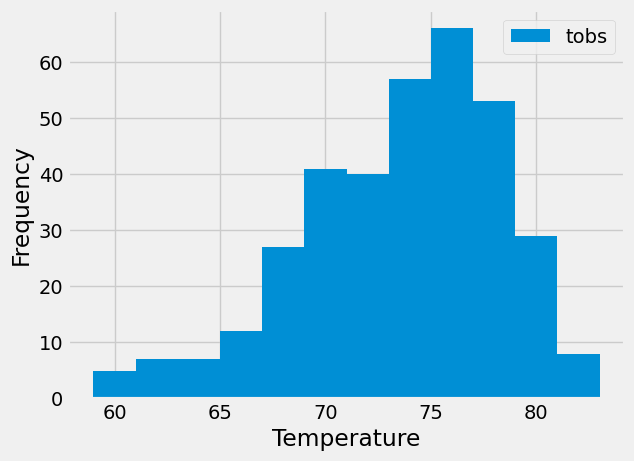

In [81]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_query = session.query(Measurement.tobs)\
    .filter(Measurement.station == active_stations[0][0])\
    .filter(Measurement.date >= starting_date).all()

temp_df = pd.DataFrame(data=temp_query)
temp_df.plot(kind="hist", xlabel="Temperature", bins=12);

# Close Session

In [16]:
# Close Session
session.close()